<a href="https://colab.research.google.com/github/lumauf/Test/blob/master/sota_model_g2p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Goal
Our main goal is to have a overview of our dataset, presenting it in a way we have at first \<start\> and at the end \<end\>, have a function defining our final input, common in all of the 5 models we'll compare, one-hot encoded, as well as our output, and finally describe our model and train and evaluate them.

Later on, I'll be writing a lot more about the presented models, how to parameter all the layers and the one hot encoding especially.

## Import and overview of the dataset

Let's do all the import we need, basically we try to keep it as simple and forward as possible, using Tensorflow as our deep learning tool.

In [ ]:
import pandas as pd
import numpy as np
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, LSTM, Activation, Bidirectional, Conv1D, BatchNormalization, ReLU, Softmax, Masking
# Matplotlib for later
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# We have to mount our drive to have access to our data and save our model
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/My Drive/Colab Notebooks/dictionnaire.csv"
PATH = "/content/drive/My Drive/Colab Notebooks/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Let's import and overview our data, which has already been a bit preprocessed.

In [ ]:
max_fr = 31
max_ph = 18
max_total = max(max_fr, max_ph)
# It's our alphabet
alphabet_fr = ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'é', 'è', 'ê', 'ë', 'î', 'ô', 'ù', 'û', 'ü']
liste_fr = [i for i in range(len(alphabet_fr))]
alphabet_ph= ['.', 'i', 'e', 'ɛ', 'a', 'y', 'ø', 'ə', 'œ', 'u', 'o', 'ɔ', 'ɑ', 'ɛ̃', 'œ̃', 'ɔ̃', 'ɑ', 'j', 'w', 'ɥ', 'p', 'b', 't', 'd', 'f', 'v', 'k', 'g', 's', 'z', 'ʃ', 'ʒ', 'ʁ', 'l', 'm', 'n', 'ɲ', 'ŋ']
liste_ph = [i for i in range(len(alphabet_ph))]

# Here is our dictionnaries
fr_train = pd.read_csv(PATH + "fr_train.csv", index_col = 0).reset_index(drop=True)
fr_test = pd.read_csv(PATH + "fr_test.csv", index_col = 0).reset_index(drop=True)
ph_train = pd.read_csv(PATH + "ph_train.csv", index_col = 0).reset_index(drop=True)
ph_test = pd.read_csv(PATH + "ph_test.csv", index_col = 0).reset_index(drop=True)
# And here a map of our dictionnaries
def mapping(alphabet, liste):
    mapping = {}
    for i in range(len(alphabet)):
        mapping[alphabet[i]]=liste[i] + 1
    return(mapping)
dict_fr_encode = mapping(alphabet_fr, liste_fr)
dict_ph_encode = mapping(alphabet_ph, liste_ph)
def un_mapping(alphabet, liste):
  mapping = {}
  for i in range(len(alphabet)):
    mapping[liste[i]+1] = alphabet[i]
  return(mapping)
dict_encode_fr = un_mapping(alphabet_fr, liste_fr)
dict_encode_ph = un_mapping(alphabet_ph, liste_ph)

In [ ]:
len(alphabet_ph)

38

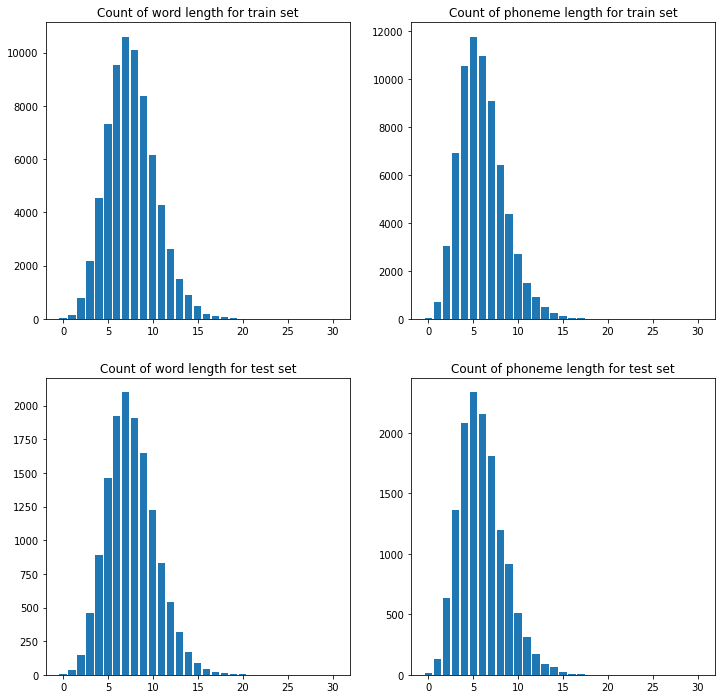

In [ ]:
data = pd.read_csv(FILE_PATH)
data = data[["fr", "ph"]]

fr = fr_train["fr"]
ph = ph_train["ph"]
fr_t = fr_test["fr"]
ph_t = ph_test["ph"]

taille_fr = []
taille_ph = []
taille_fr_t = []
taille_ph_t = []

for i in range(fr.shape[0]):
    taille_fr.append(len(fr.iloc[i]))
    taille_ph.append(len(ph.iloc[i]))

for i in range(fr_t.shape[0]):
    taille_fr_t.append(len(fr_t.iloc[i]))
    taille_ph_t.append(len(ph_t.iloc[i]))

taille_fr = pd.DataFrame(taille_fr, columns = ['longueur'])
taille_ph = pd.DataFrame(taille_ph, columns = ['longueur'])
taille_fr_t = pd.DataFrame(taille_fr_t, columns = ['longueur'])
taille_ph_t = pd.DataFrame(taille_ph_t, columns = ['longueur'])

count_fr = [0 for i in range(31)]
count_ph = [0 for i in range(31)]
count_fr_t = [0 for i in range(31)]
count_ph_t = [0 for i in range(31)]

for i in range(fr.shape[0]):
    count_fr[taille_fr.iloc[i][0]-1] += 1
    count_ph[taille_ph.iloc[i][0]-1] += 1

for i in range(fr_t.shape[0]):
    count_fr_t[taille_fr_t.iloc[i][0]-1] += 1
    count_ph_t[taille_ph_t.iloc[i][0]-1] += 1

count_fr = pd.DataFrame(count_fr, columns = ['nombre'])
count_ph = pd.DataFrame(count_ph, columns = ['nombre'])
count_fr_t = pd.DataFrame(count_fr_t, columns = ['nombre'])
count_ph_t = pd.DataFrame(count_ph_t, columns = ['nombre'])

plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.bar(count_fr.index, count_fr['nombre'])
plt.title('Count of word length for train set')

plt.subplot(2,2,2)
plt.bar(count_ph.index, count_ph['nombre'])
plt.title('Count of phoneme length for train set')

plt.subplot(2,2,3)
plt.bar(count_fr_t.index, count_fr_t['nombre'])
plt.title('Count of word length for test set')

plt.subplot(2,2,4)
plt.bar(count_ph_t.index, count_ph_t['nombre'])
plt.title('Count of phoneme length for test set')
plt.show()

After all of this, we need to define functions to encode and decode our one-hot vectors representing our word, and then encode to one hot-matrix and decode the one-hot decode back to vector.


In [ ]:
def pre_encode(string, lg, dictionnaire):
    encoded_string = []
    string = string.lower()
    for s in string:
            if lg=='fr':
                try:
                    encoded_string.append(dictionnaire[s])
                except:
                    print("")
            else:
                try:
                    encoded_string.append(dictionnaire[s])
                except:
                    print("")
    return(encoded_string)

def encode(vector, dict_type_len):
  X = []
  for i in range(len(vector)):
    vect = []
    for j in range(dict_type_len):
      if vector[i] == j:
        vect.append(1)
      else:
        vect.append(0)
    X.append(vect)
  return(np.array(X).astype(np.float32))

def decode(matrix, dictionnaire):
  y = []
  for i in range(matrix.shape[0]):
    a = ""
    vect = matrix[i]
    for j in range(len(dictionnaire)):
      if vect[j] == 1:
        a = dictionnaire[j]
        break
      else:
        a = ""
    y.append(a)
  return(y)

It is easy to see that everything is working just fine !

In [ ]:
decode(encode(pre_encode("Bonjour", "fr", dict_fr_encode), len(alphabet_fr)), dict_encode_fr)

['b', 'o', 'n', 'j', 'o', 'u', 'r']

And finally we need our training and testing set !

In [ ]:
def padding(input_list):
    max_padding = 31
    if len(input_list) < max_padding:
        input_list = input_list + [100 for i in range(max_padding-len(input_list))]
    return(input_list)

def preparation_fr(set_type_length, set_type):
  pre_list = []
  for i in range(set_type_length):
    print(i)
    pre_list.append(pre_encode(set_type.iloc[i][0], "fr", dict_fr_encode))
  for i in range(set_type_length):
    pre_list[i] = padding(pre_list[i])
  for i in range(set_type_length):
    pre_list[i] = encode(pre_list[i], len(alphabet_fr))
  final_list = np.array(pre_list)
  return(final_list)

def preparation_ph(set_type_length, set_type):
  pre_list = []
  for i in range(set_type_length):
    pre_list.append(pre_encode(set_type.iloc[i][0], "ph", dict_ph_encode))
  for i in range(set_type_length):
    pre_list[i] = padding(pre_list[i])
  for i in range(set_type_length):
    pre_list[i] = encode(pre_list[i], len(alphabet_ph))
  final_list = np.array(pre_list)
  return(final_list)

In [ ]:
def decode_ph(vector):
  word = []
  for i in range(len(vector)):
    word.append(alphabet_ph[vector[i]])
  return(word)

In [ ]:
def decode_encode(matrix):
  vector = []
  number = 0
  for i in range(31):
    tmp_vector = matrix[i]
    for j in range(38):
      if tmp_vector[j] == 1:
        number = j
        break
    vector.append(number)
    number = 0
  for i in range(len(vector)):
    if vector[len(vector)-1] == 0:
      vector.remove(0)
  return(vector)

In [ ]:
fr_test.shape, ph_test.shape

((13839, 1), (13839, 1))

In [ ]:
X_train = preparation_fr(fr_train.shape[0], fr_train)
X_test = preparation_fr(fr_test.shape[0], fr_test)
y_train = preparation_ph(ph_train.shape[0], ph_train)
y_test = preparation_ph(ph_test.shape[0], ph_test)
nb_mots = X_test.shape[0]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 31, 40), (13839, 31, 40), (70000, 31, 38), (13839, 31, 38))

In [ ]:
print("Our X_train shape is :", X_train.shape, " and our y_train shape is : ", y_train.shape)

Our X_train shape is : (70000, 31, 40)  and our y_train shape is :  (70000, 31, 38)


Everything is now ready to make our five models.

# Model Introduction
We'll implement now our five models, all are based on the encoder-decoder principle except for n°4, supposely state-of-the-art models. The goal of all of this is to give us the keys to a strong approach to G2P problematic and ways to make it better as well as ours.
Every model section will follow this structure:
- model specification
- hyper parameters
- model architecture
- compilation and training
- evaluation

All of the final activation function are unsurprisingly softmax, and the input is of shape : (,31) since of padding and putting to same length.
Have fun !

P.S : You'll be normaly surprised by some layers called "Residual"; it is a fast way to say : "Batch Normalization + RELU + 1D-Conv"

#### General parameters

In [ ]:
number_batch = 128
number_epochs = 100
# size for one sample
input_size = (max_total, len(alphabet_fr))
output_size = (max_total, len(alphabet_ph))
input_layer = Input(shape=input_size)

# Model 1

## Specification
The most simple double LSTM type model.

## Hyper parameters
### Encoder
- LSTM 1 : 1024 units

### Decoder
- LSTM 2 : 1024 units

### Model architecture

In [ ]:
encoder = Masking(mask_value=np.array([100 for i in range(len(alphabet_fr))]))(input_layer)
encoder = LSTM(1024, return_sequences=True)(encoder)
decoder = LSTM(1024, return_sequences=True)(encoder)
decoder = LSTM(38, return_sequences=True, activation = 'softmax')(decoder)

In [ ]:
model_1_LSTM_LSTM = Model(inputs=input_layer, outputs=decoder, name='model_1_LSTM_LSTM')
print(model_1_LSTM_LSTM.summary())
# problem right here with the plot_model, stil don't know why...
#plot_model(model_1_LSTM_LSTM, 'model')

Model: "model_1_LSTM_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 40)]          0         
_________________________________________________________________
masking (Masking)            (None, 31, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 31, 1024)          4362240   
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 1024)          8392704   
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 38)            161576    
Total params: 12,916,520
Trainable params: 12,916,520
Non-trainable params: 0
_________________________________________________________________
None


### Compiling, Training and Evaluating

Compiling

In [ ]:
model_1_LSTM_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training

In [ ]:
history_1 = model_1_LSTM_LSTM.fit(X_train, y_train, batch_size=number_batch, epochs=number_epochs, validation_data=(X_test, y_test))

Epoch 1/140
16/16 - 5s - loss: 0.0245 - accuracy: 0.0195 - val_loss: 0.0269 - val_accuracy: 0.0190
Epoch 2/140
16/16 - 2s - loss: 0.0191 - accuracy: 0.0142 - val_loss: 0.0229 - val_accuracy: 0.0190
Epoch 3/140
16/16 - 2s - loss: 0.0182 - accuracy: 0.0142 - val_loss: 0.0226 - val_accuracy: 0.0190
Epoch 4/140
16/16 - 2s - loss: 0.0179 - accuracy: 0.0142 - val_loss: 0.0223 - val_accuracy: 0.0190
Epoch 5/140
16/16 - 2s - loss: 0.0176 - accuracy: 0.0142 - val_loss: 0.0220 - val_accuracy: 0.0190
Epoch 6/140
16/16 - 2s - loss: 0.0175 - accuracy: 0.0142 - val_loss: 0.0216 - val_accuracy: 0.0190
Epoch 7/140
16/16 - 2s - loss: 0.0174 - accuracy: 0.0142 - val_loss: 0.0216 - val_accuracy: 0.0190
Epoch 8/140
16/16 - 2s - loss: 0.0173 - accuracy: 0.0142 - val_loss: 0.0217 - val_accuracy: 0.0190
Epoch 9/140
16/16 - 2s - loss: 0.0172 - accuracy: 0.0142 - val_loss: 0.0215 - val_accuracy: 0.0190
Epoch 10/140
16/16 - 2s - loss: 0.0171 - accuracy: 0.0142 - val_loss: 0.0212 - val_accuracy: 0.0190
Epoch 11/

Evaluating

In [ ]:
test_scores_1 = model_1_LSTM_LSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores_1[0])
print('Test accuracy:', test_scores_1[1])
test_scores_1 = pd.DataFrame(test_scores_1).T
test_scores_1.columns=['loss', 'accuracy']
test_scores_1.to_csv(PATH+'model_1_scores.csv')

7/7 - 0s - loss: 0.0281 - accuracy: 0.0971
Test loss: 0.028118561953306198
Test accuracy: 0.0970967710018158


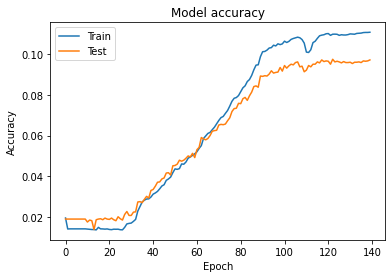

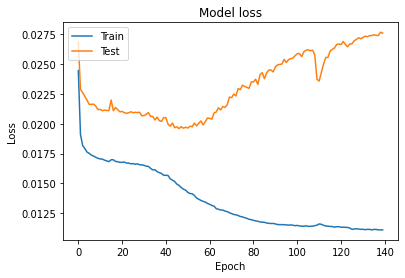

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Saving our model

In [ ]:
model_1_LSTM_LSTM.save(PATH + 'model_1_LSTM_LSTM.h5')

#### Testing our solution
Let's see how our translator really works, and lets give him a chance to be somewhat efficient.

We can try it out with our test set (which works pretty well):


In [ ]:
index = 100
X = X_test[index]
X = tf.expand_dims(X, 0)
print('X is "{0}" and is supposed to be translated as "{1}"'.format(fr_test.iloc[index][0], ph_test.iloc[index][0]))
print('X is supposed to be encoded as {0} and translated as {1}'.format(pre_encode(fr_test.iloc[index][0], "fr", dict_fr_encode),pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode) ))

X is "pirates" and is supposed to be translated as "piʁat"
X is supposed to be encoded as [18, 10, 20, 2, 22, 6, 21] and translated as [21, 2, 33, 5, 23]


Or something more random (which doesn't work so well right now, I guess for some lack of data in *training*)

In [ ]:
#X = "coucou"
#X = "bonjour"
X = "salut"
#X = "courgette"
X = pre_encode(X, "fr", dict_fr_encode)
X = padding(X)
X = encode(X, len(alphabet_fr))
X = tf.expand_dims(X, 0)
#expected = [27, 10, 27, 10]
#expected = [22, 16, 32, 10, 33]
expected = [29, 5, 34, 6]
#expected = [27, 10, 33, 32, 4, 22]
X.shape

TensorShape([1, 31, 40])

In [ ]:
arg_max = []
arg_max_value = 0
val_max = []
val_max_value = []
for i in range(31):
  arg_max.append(np.argsort(model_1_LSTM_LSTM.predict(X)[0][i])[-3:])
  arg_max_value = np.argsort(model_1_LSTM_LSTM.predict(X)[0][i])[-3:]
  val_max.append(np.sort(model_1_LSTM_LSTM.predict(X)[0][i])[-3:])
  val_max_value = np.sort(model_1_LSTM_LSTM.predict(X)[0][i])[-3:]
  print(arg_max_value, val_max_value)

[27 25 21] [0.0004726  0.02136329 0.06839716]
[ 4 18  2] [0.00102567 0.02510236 0.06843863]
[ 4 21 33] [1.4485319e-05 2.3193799e-05 6.7731634e-02]
[17  5  4] [0.01469045 0.0147679  0.02684129]
[29 30 23] [2.9971883e-05 1.5256447e-03 6.8096079e-02]
[17  8 35] [5.0568469e-05 9.9159067e-04 1.0105907e-03]
[17 29 23] [6.2661934e-07 4.2384067e-06 5.5714681e-06]
[18  8 12] [2.1157673e-07 4.5459680e-07 1.1862602e-06]
[18 12 21] [8.2482217e-08 9.3330307e-08 1.9446777e-07]
[ 8 26  3] [4.5794625e-08 5.4306511e-08 4.3586655e-07]
[ 8 21  3] [5.3396814e-08 9.3583900e-08 1.3118139e-07]
[ 8 21  3] [3.0406486e-08 6.0458213e-08 7.6097827e-08]
[13 21  3] [3.1712894e-08 4.9072231e-08 5.1791442e-08]
[13  3 21] [2.9794755e-08 3.7531155e-08 3.9598763e-08]
[13  3 21] [2.4055870e-08 2.9084436e-08 3.1313558e-08]
[20  3 21] [1.9235712e-08 1.9240186e-08 2.2421688e-08]
[ 3 20 21] [1.1873823e-08 1.3236738e-08 1.4508042e-08]
[ 3 20 21] [7.5039450e-09 8.4139504e-09 8.8992245e-09]
[20 21 19] [5.1067346e-09 5.1987801e-

It seems like 10^{-2} is the right threshold ! After testing it needs to be search more profoundly !



In [ ]:
word_prediction = []
for i in range(31):
  if arg_max[i][2] == 28:
    break
  else:
    if val_max[i][2] < 0.01:
      break
    else:
      word_prediction.append(arg_max[i][2])

word_real = pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode)
#word_real = expected
print("We are supposed to have : {}, our prediction is : {}".format(word_real, word_prediction))

word_predicted = []
for i in range(len(word_prediction)):
    word_predicted.append(alphabet_ph[word_prediction[i]-1])

print("The real prediction is :", word_predicted)

We are supposed to have : [21, 2, 33, 5, 23], our prediction is : [21, 2, 33, 4, 23]
The real prediction is : ['p', 'i', 'ʁ', 'ɛ', 't']


# Model 2

## Specification
A double BI-LSTM type model.

## Hyper parameters
### Encoder
- BI-LSTM 1 : 1024 units

### Decoder
- BI-LSTM 2 : 1024 units

### Model architecture

In [ ]:
encoder = Masking(mask_value=np.array([100 for i in range(len(alphabet_fr))]))(input_layer)
encoder = Bidirectional(LSTM(1024, return_sequences=True))(encoder)
decoder = Bidirectional(LSTM(1024, return_sequences=True))(encoder)
decoder = LSTM(38, return_sequences=True, activation = 'softmax')(decoder)

In [ ]:
model_2_BiLSTM_BiLSTM = Model(inputs=input_layer, outputs=decoder, name='model_2_BiLSTM_BiLSTM')
print(model_2_BiLSTM_BiLSTM.summary())
# problem right here with the plot_model, stil don't know why...
#plot_model(model_2_BiLSTM_BiLSTM, 'model')

Model: "model_2_BiLSTM_BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 40)]          0         
_________________________________________________________________
masking (Masking)            (None, 31, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 31, 2048)          8724480   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 2048)          25174016  
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 38)            317224    
Total params: 34,215,720
Trainable params: 34,215,720
Non-trainable params: 0
_________________________________________________________________
None


### Compiling, Training and Evaluating

Compiling

In [ ]:
model_2_BiLSTM_BiLSTM = tf.keras.models.load_model(PATH + 'model_re_model_2_BiLSTM_BiLSTM.h5')
model_2_BiLSTM_BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training

In [ ]:
history_2 = model_2_BiLSTM_BiLSTM.fit(X_train, y_train, batch_size=number_batch, epochs=number_epochs, validation_data=(X_test, y_test))

Epoch 1/100
547/547 [==============================] - 138s 252ms/step - loss: 0.0221 - accuracy: 0.0497 - val_loss: 0.0189 - val_accuracy: 0.0818
Epoch 2/100
547/547 [==============================] - 133s 243ms/step - loss: 0.0177 - accuracy: 0.1017 - val_loss: 0.0167 - val_accuracy: 0.1292
Epoch 3/100
547/547 [==============================] - 133s 243ms/step - loss: 0.0163 - accuracy: 0.1472 - val_loss: 0.0159 - val_accuracy: 0.1569
Epoch 4/100
547/547 [==============================] - 132s 242ms/step - loss: 0.0157 - accuracy: 0.1673 - val_loss: 0.0155 - val_accuracy: 0.1723
Epoch 5/100
547/547 [==============================] - 132s 242ms/step - loss: 0.0153 - accuracy: 0.1774 - val_loss: 0.0153 - val_accuracy: 0.1784
Epoch 6/100
547/547 [==============================] - 132s 241ms/step - loss: 0.0151 - accuracy: 0.1842 - val_loss: 0.0152 - val_accuracy: 0.1862
Epoch 7/100
547/547 [==============================] - 132s 242ms/step - loss: 0.0149 - accuracy: 0.1887 - val_loss: 0

Evaluating

In [ ]:
test_scores_2 = model_2_BiLSTM_BiLSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores_2[0])
print('Test accuracy:', test_scores_2[1])
test_scores_2 = pd.DataFrame(test_scores_2).T
test_scores_2.columns=['loss', 'accuracy']
test_scores_2.to_csv(PATH+'model_2_scores.csv')

433/433 - 11s - loss: 0.0159 - accuracy: 0.2108
Test loss: 0.015874242410063744
Test accuracy: 0.21076247096061707


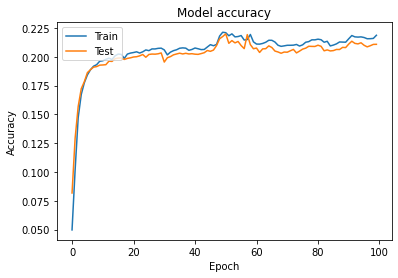

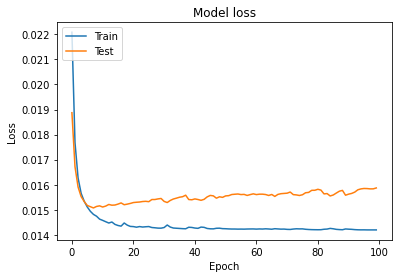

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Saving our model

In [ ]:
model_2_BiLSTM_BiLSTM.save(PATH + 'model_re_2_BiLSTM_BiLSTM.h5')

#### Testing our solution
Let's see how our translator really works, and lets give him a chance to be somewhat efficient.

We can try it out with our test set (which works pretty well):



In [ ]:
index = 161
X = X_test[index]
X = tf.expand_dims(X, 0)
print('X is "{0}" and is supposed to be translated as "{1}"'.format(fr_test.iloc[index][0], ph_test.iloc[index][0]))
print('X is supposed to be encoded as {0} and translated as {1}'.format(pre_encode(fr_test.iloc[index][0], "fr", dict_fr_encode),pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode) ))

Or something more random (which doesn't work so well right now, I guess for some lack of data in *training*)

In [ ]:
#X = "coucou"
#X = "bonjour"
#X = "salut"
#X = "courgette"
X = "gros"
X = pre_encode(X, "fr", dict_fr_encode)
X = padding(X)
X = encode(X, len(alphabet_fr))
X = tf.expand_dims(X, 0)
#expected = [27, 10, 27, 10]
#expected = [22, 16, 32, 10, 33]
#expected = [29, 5, 34, 6]
expected = [27, 10, 33, 32, 4, 22]
X.shape

TensorShape([1, 31, 40])

In [ ]:
arg_max = []
arg_max_value = 0
val_max = []
val_max_value = []
for i in range(31):
  arg_max.append(np.argsort(model_2_BiLSTM_BiLSTM.predict(X)[0][i])[-3:])
  arg_max_value = np.argsort(model_2_BiLSTM_BiLSTM.predict(X)[0][i])[-3:]
  val_max.append(np.sort(model_2_BiLSTM_BiLSTM.predict(X)[0][i])[-3:])
  val_max_value = np.sort(model_2_BiLSTM_BiLSTM.predict(X)[0][i])[-3:]
  print(arg_max_value, val_max_value)

[ 6 12 33] [4.7739154e-06 6.0204064e-05 6.8251349e-02]
[29 12 11] [1.0676248e-06 1.8677637e-02 6.8621084e-02]
[26 30 29] [1.0670780e-07 8.7902873e-07 1.2364812e-03]
[13  8  7] [3.0183440e-08 8.4362433e-08 1.2904404e-07]
[16 13  1] [1.0238946e-08 1.2740836e-08 1.2763194e-08]
[15 13  1] [1.0238404e-08 1.3360988e-08 1.5059387e-08]
[15  1 13] [5.8209970e-09 6.0355627e-09 6.9810793e-09]
[ 1 13 14] [2.5151956e-09 3.1250329e-09 7.1252741e-09]
[15 13 14] [8.7445268e-10 1.2414949e-09 3.8551176e-09]
[15 13 14] [3.5116698e-10 4.4992196e-10 2.8319922e-09]
[15 13 14] [1.2790718e-10 1.9474984e-10 1.8471896e-09]
[15 13 14] [4.4930483e-11 7.2734672e-11 1.4455982e-09]
[15 13 14] [1.9045418e-11 2.5027017e-11 1.7935802e-09]
[ 1 13 14] [6.8674324e-12 9.9647530e-12 1.5571167e-09]
[ 1 13 14] [2.6606070e-12 4.0001500e-12 1.9140052e-09]
[ 1 13 14] [1.0864777e-12 1.3864820e-12 1.6313086e-09]
[ 1 13 14] [3.8377903e-13 5.0309198e-13 1.4541021e-09]
[ 1 13 14] [1.4376137e-13 1.7969519e-13 1.2512529e-09]
[ 1 13 14]

In [ ]:
word_prediction = []
for i in range(31):
  if arg_max[i][2] == 28:
    break
  else:
    if val_max[i][2] < 0.01:
      break
    else:
      word_prediction.append(arg_max[i][2])

#word_real = pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode)
word_real = expected
print("We are supposed to have : {}, our prediction is : {}".format(word_real, word_prediction))

word_predicted = []
for i in range(len(word_prediction)):
    word_predicted.append(alphabet_ph[word_prediction[i]-1])

print("The real prediction is :", word_predicted)

We are supposed to have : [27, 10, 33, 32, 4, 22], our prediction is : [33, 11]
The real prediction is : ['ʁ', 'o']


# Model 3

## Specification
A convolutional-BI-LSTM type model.

## Hyper parameters
### Encoder
- 1D-Convolutional : 
- Batch Normalization : 

### Decoder
- BI-LSTM 2 : 1024 units

### Model architecture

In [ ]:
encoder = Masking(mask_value=np.array([100 for i in range(len(alphabet_fr))]))(input_layer)
encoder = Conv1D(filters = 524, kernel_size=1, strides=1, padding='same')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = ReLU()(encoder)
decoder = Bidirectional(LSTM(1024, return_sequences=True))(encoder)
decoder = LSTM(38, return_sequences=True, activation = 'softmax')(decoder)

NameError: ignored

In [ ]:
model_3_Conv1D_BiLSTM = Model(inputs=input_layer, outputs=decoder, name='model_3_Conv1D_BiLSTM')
print(model_3_Conv1D_BiLSTM.summary())
# problem right here with the plot_model, stil don't know why...
#plot_model(model_3_Conv1D_BiLSTM, 'model')

### Compiling, Training, Evaluating

Compiling

In [ ]:
model_3_Conv1D_BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training

In [ ]:
history_3 = model_3_Conv1D_BiLSTM.fit(X_train, y_train, batch_size=number_batch, epochs=number_epochs, validation_data=(X_test, y_test))

Evaluating

In [ ]:
test_scores_3 = model_3_Conv1D_BiLSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores_3[0])
print('Test accuracy:', test_scores_3[1])
test_scores_3 = pd.DataFrame(test_scores_3).T
test_scores_3.columns=['loss', 'accuracy']
test_scores_3.to_csv(PATH+'model_3_scores.csv')

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Saving our model

In [ ]:
model_3_Conv1D_BiLSTM.save(PATH + 'model_3_Conv1D_BiLSTM.h5')

#### Testing our solution
Let's see how our translator really works, and lets give him a chance to be somewhat efficient.

We can try it out with our test set (which works pretty well):



In [ ]:
index = 100
X = X_test[index]
X = tf.expand_dims(X, 0)
print('X is "{0}" and is supposed to be translated as "{1}"'.format(fr_test.iloc[index][0], ph_test.iloc[index][0]))
print('X is supposed to be encoded as {0} and translated as {1}'.format(pre_encode(fr_test.iloc[index][0], "fr", dict_fr_encode),pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode) ))

Or something more random (which doesn't work so well right now, I guess for some lack of data in *training*)



In [ ]:
#X = "coucou"
#X = "bonjour"
#X = "salut"
X = "courgette"
X = pre_encode(X, "fr", dict_fr_encode)
X = padding(X)
X = encode(X, len(alphabet_fr))
X = tf.expand_dims(X, 0)
#expected = [27, 10, 27, 10]
#expected = [22, 16, 32, 10, 33]
#expected = [29, 5, 34, 6]
expected = [27, 10, 33, 32, 4, 22]
X.shape

In [ ]:
arg_max = []
arg_max_value = 0
val_max = []
val_max_value = []
for i in range(31):
  arg_max.append(np.argsort(model_3_Conv1D_BiLSTM.predict(X)[0][i])[-3:])
  arg_max_value = np.argsort(model_3_Conv1D_BiLSTM.predict(X)[0][i])[-3:]
  val_max.append(np.sort(model_3_Conv1D_BiLSTM.predict(X)[0][i])[-3:])
  val_max_value = np.sort(model_3_Conv1D_BiLSTM.predict(X)[0][i])[-3:]
  print(arg_max_value, val_max_value)

In [ ]:
word_prediction = []
for i in range(31):
  if arg_max[i][2] == 28:
    break
  else:
    if val_max[i][2] < 0.01:
      break
    else:
      word_prediction.append(arg_max[i][2])

word_real = pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode)
#word_real = expected
print("We are supposed to have : {}, our prediction is : {}".format(word_real, word_prediction))

word_predicted = []
for i in range(len(word_prediction)):
    word_predicted.append(alphabet_ph[word_prediction[i]-1])

print("The real prediction is :", word_predicted)

# Model 4

## Specification
A functional convolutional type model, this one is not based on the encoder-decoder principle.

## Hyper parameters
### Block 1
- 1D-Convolutional : number of filters : 64, length of filter : 23, stride : 1

### Block 2
- Residual : number of filters : 64, length of filter : 3, stride : 1
- Residual : number of filters : 128, length of filter : 3, stride : 1
- Residual : number of filters : 256, length of filter : 3, stride : 1
- Residual : number of filters : 512, length of filter : 3, stride : 1




### Model architecture

In [ ]:
encoder = Masking(mask_value=np.array([100 for i in range(len(alphabet_fr))]))(input_layer)
encoder = Conv1D(filters = 64, kernel_size=3, strides=1, padding = 'same')(encoder)

block1 = BatchNormalization()(encoder)
block1 = ReLU()(block1)
block1 = Conv1D(filters = 64, kernel_size=3, padding = 'same')(block1)

block2 = BatchNormalization()(block1)
block2 = ReLU()(block2)
block2 = Conv1D(filters = 128, kernel_size=3, padding = 'same')(block2)

block3 = BatchNormalization()(block2)
block3 = ReLU()(block3)
block3 = Conv1D(filters = 256, kernel_size=3, padding = 'same')(block3)

block4 = BatchNormalization()(block3)
block4 = ReLU()(block4)
block4 = Conv1D(filters = 512, kernel_size=3, padding = 'same')(block4)

decoder = BatchNormalization()(block4)
decoder = ReLU()(decoder)

decoder = LSTM(38, return_sequences=True, activation = 'softmax')(decoder)

In [ ]:
model_4_Conv1D_Residuals = Model(inputs=input_layer, outputs=decoder, name='model_4_Conv1D_Residuals')
print(model_4_Conv1D_Residuals.summary())
# problem right here with the plot_model, stil don't know why...
#plot_model(model_4_Conv1D_Residuals, 'model')

### Compiling, Training and Evaluating

Compiling

In [ ]:
model_4_Conv1D_Residuals.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training

In [ ]:
history_4 = model_4_Conv1D_Residuals.fit(X_train, y_train, batch_size=number_batch, epochs=number_epochs, validation_data=(X_test, y_test))

Evaluating

In [ ]:
test_scores_4 = model_4_Conv1D_Residuals.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores_4[0])
print('Test accuracy:', test_scores_4[1])
test_scores_4 = pd.DataFrame(test_scores_4).T
test_scores_4.columns=['loss', 'accuracy']
test_scores_4.to_csv(PATH+'model_4_scores.csv')

In [ ]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Saving our model

In [ ]:
model_4_Conv1D_Residuals.save(PATH + 'model_4_Conv1D_Residuals.h5')

#### Testing our solution
Let's see how our translator really works, and lets give him a chance to be somewhat efficient.

We can try it out with our test set (which works pretty well):



In [ ]:
index = 50
X = X_test[index]
X = tf.expand_dims(X, 0)
print('X is "{0}" and is supposed to be translated as "{1}"'.format(fr_test.iloc[index][0], ph_test.iloc[index][0]))
print('X is supposed to be encoded as {0} and translated as {1}'.format(pre_encode(fr_test.iloc[index][0], "fr", dict_fr_encode),pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode) ))

Or something more random (which doesn't work so well right now, I guess for some lack of data in *training*)


In [ ]:
#X = "coucou"
#X = "bonjour"
#X = "salut"
X = "courgette"
X = pre_encode(X, "fr", dict_fr_encode)
X = padding(X)
X = encode(X, len(alphabet_fr))
X = tf.expand_dims(X, 0)
expected = [27, 10, 27, 10]
#expected = [22, 16, 32, 10, 33]
#expected = [29, 5, 34, 6]
expected = [27, 10, 33, 32, 4, 22]
X.shape

In [ ]:
arg_max = []
arg_max_value = 0
val_max = []
val_max_value = []
for i in range(31):
  arg_max.append(np.argsort(model_4_Conv1D_Residuals.predict(X)[0][i])[-3:])
  arg_max_value = np.argsort(model_4_Conv1D_Residuals.predict(X)[0][i])[-3:]
  val_max.append(np.sort(model_4_Conv1D_Residuals.predict(X)[0][i])[-3:])
  val_max_value = np.sort(model_4_Conv1D_Residuals.predict(X)[0][i])[-3:]
  print(arg_max_value, val_max_value)

In [ ]:
word_prediction = []
for i in range(31):
  if arg_max[i][2] == 28:
    break
  else:
    if val_max[i][2] < 0.001:
      break
    else:
      word_prediction.append(arg_max[i][2])

word_real = pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode)
#word_real = expected
print("We are supposed to have : {}, our prediction is : {}".format(word_real, word_prediction))

word_predicted = []
for i in range(len(word_prediction)):
    word_predicted.append(alphabet_ph[word_prediction[i]-1])

print("The real prediction is :", word_predicted)

We are supposed to have : [27, 20, 2, 33], our prediction is : [27, 20, 2, 33]
The real prediction is : ['k', 'ɥ', 'i', 'ʁ']



# Model 5

## Specification
A functional convolutional-BI-LSTM type model, this time based on the encoder-decoder principle.

## Hyper parameters
### Encoder
- 1D-Convolutional : number of filters : 64, length of filter : 23, stride : 1
- Residual : number of filters : 64, length of filter : 3, stride : 1
- Residual : number of filters : 128, length of filter : 3, stride : 1
- Residual : number of filters : 256, length of filter : 3, stride : 1
- Residual : number of filters : 512, length of filter : 3, stride : 1

### Decoder
- BI-LSTM : 1024 units





### Model architecture

In [ ]:
#encoder = Masking(mask_value=np.array([100 for i in range(len(alphabet_fr))]))(input_layer)
encoder = Masking(mask_value=np.array([100 for i in range(40)]))(input_layer)
encoder = Conv1D(filters = 64, kernel_size=3, strides=1, padding = 'same')(encoder)

block1 = BatchNormalization()(encoder)
block1 = ReLU()(block1)
block1 = Conv1D(filters = 64, kernel_size=1, padding = 'same')(block1)

block2 = BatchNormalization()(block1)
block2 = ReLU()(block2)
block2 = Conv1D(filters = 128, kernel_size=1, padding = 'same')(block2)

block3 = BatchNormalization()(block2)
block3 = ReLU()(block3)
block3 = Conv1D(filters = 256, kernel_size=1, padding = 'same')(block3)

block4 = BatchNormalization()(block3)
block4 = ReLU()(block4)
block4 = Conv1D(filters = 512, kernel_size=1, padding = 'same')(block4)

decoder = BatchNormalization()(block4)
decoder = ReLU()(decoder)

decoder = Bidirectional(LSTM(1024, return_sequences=True))(decoder)
decoder = LSTM(38, activation = 'softmax', return_sequences=True)(decoder)

In [ ]:
model_5_Conv1D_Residuals_BiLSTM = Model(inputs=input_layer, outputs=decoder, name='model_5_Conv1D_Residuals_BiLSTM')
print(model_5_Conv1D_Residuals_BiLSTM.summary())
# problem right here with the plot_model, stil don't know why...
#plot_model(model_5_Conv1D_Residuals_BiLSTM, 'model')

Model: "model_5_Conv1D_Residuals_BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31, 40)]          0         
_________________________________________________________________
masking_1 (Masking)          (None, 31, 40)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 31, 64)            7744      
_________________________________________________________________
batch_normalization_5 (Batch (None, 31, 64)            256       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 31, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 31, 64)            4160      
_________________________________________________________________
batch_normalization_6 (Batch (None,

### Compiling, Training, Evaluating 

Compiling

In [ ]:
model_5_Conv1D_Residuals_BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training

In [ ]:
history_5 = model_5_Conv1D_Residuals_BiLSTM.fit(X_train, y_train, batch_size=number_batch, epochs=number_epochs, validation_data=(X_train, y_train))

Epoch 1/140
547/547 [==============================] - 71s 130ms/step - loss: 0.0178 - accuracy: 0.2203 - val_loss: 0.0162 - val_accuracy: 0.1469
Epoch 2/140
547/547 [==============================] - 70s 128ms/step - loss: 0.0157 - accuracy: 0.1671 - val_loss: 0.0155 - val_accuracy: 0.1778
Epoch 3/140
547/547 [==============================] - 70s 127ms/step - loss: 0.0154 - accuracy: 0.1778 - val_loss: 0.0152 - val_accuracy: 0.1806
Epoch 4/140
547/547 [==============================] - 71s 129ms/step - loss: 0.0152 - accuracy: 0.1827 - val_loss: 0.0151 - val_accuracy: 0.1841
Epoch 5/140
547/547 [==============================] - 71s 129ms/step - loss: 0.0151 - accuracy: 0.1852 - val_loss: 0.0150 - val_accuracy: 0.1885
Epoch 6/140
547/547 [==============================] - 71s 129ms/step - loss: 0.0150 - accuracy: 0.1870 - val_loss: 0.0149 - val_accuracy: 0.1887
Epoch 7/140
547/547 [==============================] - 70s 128ms/step - loss: 0.0149 - accuracy: 0.1892 - val_loss: 0.0149 -

Evaluating

In [ ]:
test_scores_5 = model_5_Conv1D_Residuals_BiLSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores_5[0])
print('Test accuracy:', test_scores_5[1])
test_scores_5 = pd.DataFrame(test_scores_5).T
test_scores_5.columns=['loss', 'accuracy']
test_scores_5.to_csv(PATH+'model_5_scores.csv')

433/433 - 6s - loss: 0.0160 - accuracy: 0.2161
Test loss: 0.01595938764512539
Test accuracy: 0.21613065898418427


,loss,accuracy
0,0.015959,0.216131


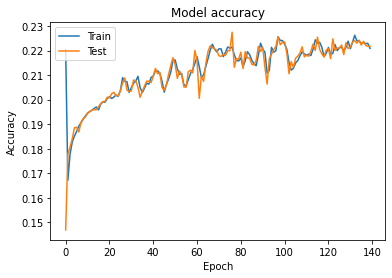

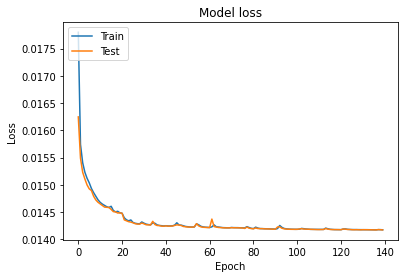

In [ ]:
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Saving our model

In [ ]:
model_5_Conv1D_Residuals_BiLSTM.save(PATH + 'model_5_Conv1D_Residuals_BiLSTM.h5')

#### Testing our solution
Let's see how our translator really works, and lets give him a chance to be somewhat efficient.

We can try it out with our test set (which works pretty well):



In [ ]:
index = 160
X = X_test[index]
X = tf.expand_dims(X, 0)
print('X is "{0}" and is supposed to be translated as "{1}"'.format(fr_test.iloc[index][0], ph_test.iloc[index][0]))
print('X is supposed to be encoded as {0} and translated as {1}'.format(pre_encode(fr_test.iloc[index][0], "fr", dict_fr_encode),pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode) ))

X is "attelages" and is supposed to be translated as "atlaʒ"
X is supposed to be encoded as [2, 22, 22, 6, 14, 2, 8, 6, 21] and translated as [5, 23, 34, 5, 32]


Or something more random (which doesn't work so well right now, I guess for some lack of data in *training*)


In [ ]:
#X = "coucou"
#X = "bonjour"
#X = "salut"
X = "gouine"
X = pre_encode(X, "fr", dict_fr_encode)
X = padding(X)
X = encode(X, len(alphabet_fr))
X = tf.expand_dims(X, 0)
#expected = [27, 10, 27, 10]
#expected = [22, 16, 32, 10, 33]
#expected = [29, 5, 34, 6]
expected = [27, 10, 33, 32, 4, 22]
X.shape

TensorShape([1, 31, 40])

In [ ]:
arg_max = []
arg_max_value = 0
val_max = []
val_max_value = []
for i in range(31):
  arg_max.append(np.argsort(model_5_Conv1D_Residuals_BiLSTM.predict(X)[0][i])[-3:])
  arg_max_value = np.argsort(model_5_Conv1D_Residuals_BiLSTM.predict(X)[0][i])[-3:]
  val_max.append(np.sort(model_5_Conv1D_Residuals_BiLSTM.predict(X)[0][i])[-3:])
  val_max_value = np.sort(model_5_Conv1D_Residuals_BiLSTM.predict(X)[0][i])[-3:]
  print(arg_max_value, val_max_value)

[10  2 19] [5.1994903e-07 2.4965439e-02 2.5175501e-02]
[36 19  2] [0.0020166  0.0207484  0.07990412]
[19  2 36] [1.7972692e-05 1.2409332e-02 1.3720600e-01]
[ 1 36 33] [1.1284100e-08 4.1329872e-07 5.7265743e-07]
[13 14  1] [1.5779117e-09 1.9420534e-09 2.0714730e-09]
[ 1  0 15] [1.3674040e-09 1.3903128e-09 1.4466980e-09]
[16 15  1] [4.5986029e-10 5.2269361e-10 6.1969435e-10]
[15  1 28] [1.5334208e-10 1.6439126e-10 1.8834614e-10]
[13  1 28] [2.3790256e-10 2.5119085e-10 6.9185840e-10]
[13  1 28] [1.3988717e-10 1.8382948e-10 7.1192890e-10]
[13  1 28] [1.7438584e-10 2.3948188e-10 9.2098301e-10]
[13  1 28] [1.5116007e-10 2.1031217e-10 1.1231127e-09]
[16  1 28] [1.6461121e-10 2.3320987e-10 1.2366804e-09]
[16  1 28] [1.6904926e-10 2.4165311e-10 1.3617972e-09]
[16  1 28] [1.7024129e-10 2.4792177e-10 1.4225310e-09]
[16  1 28] [1.7447536e-10 2.5972910e-10 1.5396023e-09]
[16  1 28] [1.7420999e-10 2.6542582e-10 1.6047881e-09]
[16  1 28] [1.7743503e-10 2.7856470e-10 1.6953693e-09]
[13  1 28] [1.78885

In [ ]:
word_prediction = []
for i in range(31):
  if arg_max[i][2] == 28:
    break
  else:
    if val_max[i][2] < 0.0001:
      break
    else:
      word_prediction.append(arg_max[i][2])

#word_real = pre_encode(ph_test.iloc[index][0], "ph", dict_ph_encode)
word_real = expected
print("We are supposed to have : {}, our prediction is : {}".format(word_real, word_prediction))

word_predicted = []
for i in range(len(word_prediction)):
    word_predicted.append(alphabet_ph[word_prediction[i]-1])

print("The real prediction is :", word_predicted)

We are supposed to have : [27, 10, 33, 32, 4, 22], our prediction is : [19, 2, 36]
The real prediction is : ['w', 'i', 'n']


# Comparing the different models

The idea is here to compare our 5 models in different ways; we'll plot a comparative graph and compare values off loss, accuracy and co.

First of all, let's try to calculate different kind of errors:
- error 1: errors of length (insertion)
- error 2: errors of vocabulary (deletion)
- error 3: errors of permutation (substitution)
We then have : $$PER = \frac{error_1 + error_2 + error_3}{SupposedWordLength}$$
And: $$WER=1-\frac{WordWellPredicted}{NumberOfWords}$$

In [ ]:
def error_1(word, prediction):
  error =np.abs(len(word)-len(prediction)) 
  #return(error/len(word))
  return(error)

def error_2(word, prediction):
  error = 0
  index_max = min(len(word), len(prediction))
  for i in range(index_max-1):
    if prediction[i] != word[i]:
      if prediction[i+1] != word[i]:
        error+=1
  if prediction[index_max-1] != word[index_max-1]:
    if prediction[index_max-1] != word[index_max-2]:
      error += 1
  #return(error/len(prediction))
  return(error)

def error_3(word, prediction):
  error = 0
  index_max = min(len(word), len(prediction))
  for i in range(index_max-1):
    if prediction[i] != word[i]:
      if prediction[i+1] == word[i] and prediction[i] == word[i+1]:
        error+=1
  if prediction[index_max-1] != word[index_max-1]:
    if prediction[index_max-1] == word[index_max-2] and prediction[index_max-2] == word[index_max-1]:
      error += 1
  #return(error/(2*len(prediction)))
  return(error/2)

In [ ]:
def error_total(name, model, threshold):
  real_list = []
  prediction_list = []
  error_1_list = []
  error_2_list = []
  error_3_list = []
  per_list = []
  check_list = []
  #for i in range(X_test.shape[0]):
  for i in range(1000):
    print(name, i)
    X = X_test[i]
    X = tf.expand_dims(X, 0)
    expected = y_test[0]
    arg_max = []
    val_max = []
    for j in range(31):
      arg_max.append(np.argsort(model.predict(X)[0][j])[-3:])
      val_max.append(np.sort(model.predict(X)[0][j])[-3:])
    word_prediction = []
    for j in range(31):
      if val_max[j][2] < threshold:
        break
      else:
        word_prediction.append(arg_max[j][2])
    print("prediction : ", word_prediction, " and reality :", decode_encode(y_test[i]))
    real_list.append(str(decode_encode(y_test[i])).strip('[]').replace(' ',''))
    prediction_list.append(str(word_prediction).strip('[]').replace(' ',''))
    if len(word_prediction) != 0:
      a = error_1(decode_encode(y_test[i]), word_prediction)
      b = error_2(decode_encode(y_test[i]), word_prediction)
      c = error_3(decode_encode(y_test[i]), word_prediction)
      error_1_list.append(error_1(decode_encode(y_test[i]), word_prediction))
      error_2_list.append(error_2(decode_encode(y_test[i]), word_prediction))
      error_3_list.append(error_3(decode_encode(y_test[i]), word_prediction))
      per_list.append((a+b+c)/len(decode_encode(y_test[i])))
      if a+b+c == 0:
        check_list.append(1)
      else:
        check_list.append(0)
    if len(word_prediction) == 0:
      a = error_1(decode_encode(y_test[i]), word_prediction)
      b = 0
      c = 0
      error_1_list.append(error_1(decode_encode(y_test[i]), word_prediction))
      error_2_list.append(0)
      error_3_list.append(0)
      per_list.append((a+b+c)/len(decode_encode(y_test[i])))
      check_list.append(0)
  return(real_list, prediction_list, check_list, per_list, error_1_list, error_2_list, error_3_list)


In [ ]:
#model_1_real, model_1_prediction, model_1_cl, model_1_per, model_1_error_1, model_1_error_2, model_1_error_3 = error_total("model_1", model_1_LSTM_LSTM, 0.01)
model_2_real, model_2_prediction, model_2_cl, model_2_per, model_2_error_1, model_2_error_2, model_2_error_3 = error_total("model_2", model_2_BiLSTM_BiLSTM, 0.001)
#model_3_real, model_3_prediction, model_3_cl, model_3_per, model_3_error_1, model_3_error_2, model_3_error_3 = error_total("model_3", model_3_Conv1D_BiLSTM, 0.01)
#model_4_real, model_4_prediction, model_4_cl, model_4_per, model_4_error_1, model_4_error_2, model_4_error_3 = error_total("model_4", model_4_Conv1D_Residuals, 0.001)
#model_5_real, model_5_prediction, model_5_cl, model_5_per, model_5_error_1, model_5_error_2, model_5_error_3 = error_total("model_5", model_5_Conv1D_Residuals_BiLSTM, 0.0001)

model_2 0
prediction :  [3, 34, 19, 5, 37, 3]  and reality : [3, 34, 19, 5, 37, 3]
model_2 1
prediction :  [33, 17, 24, 12, 33]  and reality : [33, 17, 24, 12, 33]
model_2 2
prediction :  [21, 33, 4, 29, 2, 21, 5, 34]  and reality : [21, 33, 4, 29, 2, 21, 5, 34]
model_2 3
prediction :  [23, 33, 11, 36, 17]  and reality : [23, 33, 11, 36, 17]
model_2 4
prediction :  [2, 34, 3, 32, 2, 23, 2, 35]  and reality : [2, 34, 3, 32, 2, 23, 2, 35]
model_2 5
prediction :  [24, 3, 30, 17, 24, 3, 23, 3]  and reality : [24, 3, 30, 17, 24, 3, 23, 3]
model_2 6
prediction :  [27, 12, 33, 3, 34, 3]  and reality : [27, 12, 33, 3, 34, 3]
model_2 7
prediction :  [27, 12, 26, 4, 33, 23, 2, 29, 9, 33]  and reality : [27, 12, 26, 4, 33, 23, 2, 29, 9, 33]
model_2 8
prediction :  [4, 33, 3, 24, 2, 17]  and reality : [4, 33, 3, 24, 18, 17]
model_2 9
prediction :  [24, 3, 30, 5, 35, 12, 33, 29, 5, 32]  and reality : [24, 3, 30, 5, 35, 12, 33, 29, 5, 32]
model_2 10
prediction :  [5, 27, 12, 33, 24, 17]  and reality

In [ ]:
'''for i in range(nb_mots):
  model_1_real[i] = str(model_1_real[i]).strip('[]').replace(' ','')
  model_1_prediction[i] = str(model_1_prediction[i]).strip('[]').replace(' ','')
  model_2_real[i] = str(model_2_real[i]).strip('[]').replace(' ','')
  model_2_prediction[i] = str(model_2_prediction[i]).strip('[]').replace(' ','')
  model_3_real[i] = str(model_3_real[i]).strip('[]').replace(' ','')
  model_3_prediction[i] = str(model_3_prediction[i]).strip('[]').replace(' ','')
  model_4_real[i] = str(model_4_real[i]).strip('[]').replace(' ','')
  model_4_prediction[i] = str(model_4_prediction[i]).strip('[]').replace(' ','')
  model_5_real[i] = str(model_5_real[i]).strip('[]').replace(' ','')
  model_5_prediction[i] = str(model_5_prediction[i]).strip('[]').replace(' ','')
'''
for i in range(1000):
  model_2_real[i] = str(model_2_real[i]).strip('[]').replace(' ','')
  model_2_prediction[i] = str(model_2_prediction[i]).strip('[]').replace(' ','')


In [ ]:
'''model_1_error = pd.DataFrame([model_1_real, model_1_prediction, model_1_cl, model_1_per, model_1_error_1, model_1_error_2, model_1_error_3]).T
model_1_error.columns = ['real', 'prediction', 'check', 'per', 'error_1', 'error_2', 'error_3']'''
model_2_error = pd.DataFrame([model_2_real, model_2_prediction, model_2_cl, model_2_per, model_2_error_1, model_2_error_2, model_2_error_3]).T
model_2_error.columns = ['real', 'prediction', 'check', 'per', 'error_1', 'error_2', 'error_3']
'''model_3_error = pd.DataFrame([model_3_real, model_3_prediction, model_3_cl, model_3_per, model_3_error_1, model_3_error_2, model_3_error_3]).T
model_3_error.columns = ['real', 'prediction', 'check', 'per', 'error_1', 'error_2', 'error_3']
model_4_error = pd.DataFrame([model_4_real, model_4_prediction, model_4_cl, model_4_per, model_4_error_1, model_4_error_2, model_4_error_3]).T
model_4_error.columns = ['real', 'prediction', 'check', 'per', 'error_1', 'error_2', 'error_3']
model_5_error = pd.DataFrame([model_5_real, model_5_prediction, model_5_cl, model_5_per, model_5_error_1, model_5_error_2, model_5_error_3]).T
model_5_error.columns = ['real', 'prediction', 'check', 'per', 'error_1', 'error_2', 'error_3']

model_1_error.to_csv(PATH + 'model_1_error.csv')'''
model_2_error.to_csv(PATH + 'model_2_error.csv')
#model_3_error.to_csv(PATH + 'model_3_error.csv')
#model_4_error.to_csv(PATH + 'model_4_error.csv')
#model_5_error.to_csv(PATH + 'model_5_error.csv')

Here we plot comparative graphs

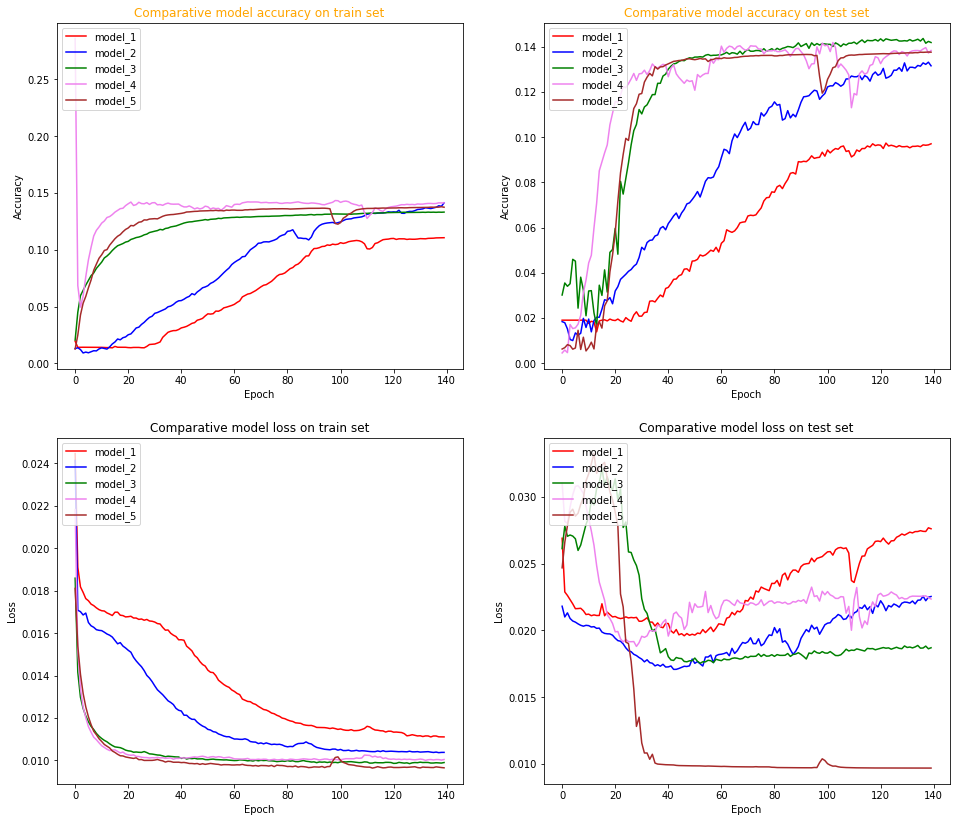

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
plt.plot(history_1.history['accuracy'], color = 'red')
plt.plot(history_2.history['accuracy'], color = 'blue')
plt.plot(history_3.history['accuracy'], color = 'green')
plt.plot(history_4.history['accuracy'], color = 'violet')
plt.plot(history_5.history['accuracy'], color = 'brown')
plt.title('Comparative model accuracy on train set', color = 'orange')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(history_1.history['val_accuracy'], color = 'red')
plt.plot(history_2.history['val_accuracy'], color = 'blue')
plt.plot(history_3.history['val_accuracy'], color = 'green')
plt.plot(history_4.history['val_accuracy'], color = 'violet')
plt.plot(history_5.history['val_accuracy'], color = 'brown')
plt.title('Comparative model accuracy on test set', color = 'orange')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(history_1.history['loss'], color = 'red')
plt.plot(history_2.history['loss'], color = 'blue')
plt.plot(history_3.history['loss'], color = 'green')
plt.plot(history_4.history['loss'], color = 'violet')
plt.plot(history_5.history['loss'], color = 'brown')
plt.title('Comparative model loss on train set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(history_1.history['val_loss'], color = 'red')
plt.plot(history_2.history['val_loss'], color = 'blue')
plt.plot(history_3.history['val_loss'], color = 'green')
plt.plot(history_4.history['val_loss'], color = 'violet')
plt.plot(history_5.history['val_loss'], color = 'brown')
plt.title('Comparative model loss on test set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'], loc='upper left')
plt.show()

plt.savefig(PATH+'comparative.png')

Finally, we make our comparative DataFrame

In [ ]:
colonne = ['model', 'loss', 'accuracy', 'approximate computational time in seconds', 'size in mb','wer', 'per_total', 'error_1_total', 'error_2_total', 'error_3_total', 'per_mean', 'error_1_mean', 'error_2_mean', 'error_3_mean']
model = ['model_1_LSTM_LSTM', 'model_2_BiLSTM_BiLSTM', 'model_3_Conv1D_BiLSTM', 'model_4_Conv1D_Residuals', 'model_5_Conv1D_Residuals_BiLSTM']
loss = [test_scores_1[0], test_scores_2[0], test_scores_3[0], test_scores_4[0], test_scores_5[0]]
accuracy = [test_scores_1[1], test_scores_2[1], test_scores_3[1], test_scores_4[1], test_scores_5[1]]
app_comp_time = ["9+2*139", "17 + 4*139", "5 + 11*2 + 1*(140-11-1)", "3 + 1*139", "7+2*139"]
app_comp_time_real = [287, 573, 155, 142, 285]
size = [151, 401, 153, 7, 150]
tab_error_1_total = [model_1_error['error_1'].sum(),model_2_error['error_1'].sum(),model_3_error['error_1'].sum(),model_4_error['error_1'].sum(),model_5_error['error_1'].sum()]
tab_error_2_total = [model_1_error['error_2'].sum(),model_2_error['error_2'].sum(),model_3_error['error_2'].sum(),model_4_error['error_2'].sum(),model_5_error['error_2'].sum()]
tab_error_3_total = [model_1_error['error_3'].sum(),model_2_error['error_3'].sum(),model_3_error['error_3'].sum(),model_4_error['error_3'].sum(),model_5_error['error_3'].sum()]
per_total = [model_1_error['per'].sum(), model_2_error['per'].sum(), model_3_error['per'].sum(),model_4_error['per'].sum(), model_5_error['per'].sum()]

tab_error_1_mean = [model_1_error['error_1'].mean(),model_2_error['error_1'].mean(),model_3_error['error_1'].mean(),model_4_error['error_1'].mean(),model_5_error['error_1'].mean()]
tab_error_2_mean = [model_1_error['error_2'].mean(),model_2_error['error_2'].mean(),model_3_error['error_2'].mean(),model_4_error['error_2'].mean(),model_5_error['error_2'].mean()]
tab_error_3_mean = [model_1_error['error_3'].mean(),model_2_error['error_3'].mean(),model_3_error['error_3'].mean(),model_4_error['error_3'].mean(),model_5_error['error_3'].mean()]
per_mean = [model_1_error['per'].mean(), model_2_error['per'].mean(), model_3_error['per'].mean(),model_4_error['per'].mean(), model_5_error['per'].mean()]

wer = [1-model_1_error['check'].sum()/nb_mots, 1-model_2_error['check'].sum()/nb_mots, 1-model_3_error['check'].sum()/nb_mots, 1-model_4_error['check'].sum()/nb_mots,1- model_5_error['check'].sum()/nb_mots]
tableau_recapitulatif = [model, loss, accuracy, app_comp_time_real, size, wer, per_total, tab_error_1_total, tab_error_2_total, tab_error_3_total, per_mean, tab_error_1_mean, tab_error_2_mean, tab_error_3_mean]
tableau_recapitulatif = pd.DataFrame(tableau_recapitulatif).T
tableau_recapitulatif.columns = colonne
tableau_recapitulatif.to_csv(PATH+'tableau_recapitulatif.csv')

In [ ]:
tableau_recapitulatif

NameError: ignored

In [ ]:
model_2_error['per'].mean()

0.05499723332223335

In [ ]:
b= pd.DataFrame(a)

In [ ]:
b.mean()

0    6.133165
dtype: float64